July 28 Updates:

Goal: one segment analysis (first segment: 0-700 m)
1. able to select time period for analysis
2. each point collection correspond to longer time
3. make only the first traffic light red or green, others will stay green
4. mean space speed

Aug 8 Updates: 
1. each dot corresponding to 2 min
2. different spawn rate, in the same plot
3. third plot scatter plot
4. check second graph relationship

Aug 19 Updates:

1. free flow and red lights 12 figures


Aug 26 Updates:
1. Offset = 0, green phase duration = 20/30/40
2. check average velocity why too small

In [1]:
### JULY 14 UPDATES 3 red lights with offsets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import copy

In [33]:
# Simulation parameters
# Aug 26: green phase duration 40 for all three traffic lights
road_length = 400  # meters
signal_position1 = 100  # meters
signal_position2 = 200  # meters
signal_position3 = 300  # meters
simulation_duration = 3600  # seconds
time_step = 1  # second
red_phase_duration = 40  # seconds
green_phase_duration = 40  # seconds
max_speed = 30  # meters/second
reaction_time = 1.5  # seconds
safe_distance = 5  # meters
normal_deceleration = -2.5  # meters/second^2
# spawn_rate = 1  # average number of vehicles spawned per second
flux = 0 # number of cars traveled across the road
average_velocity_sum = 0 # for fundamental diagram average velocity calculation
total_cars = 0 # for fundamental diagram average velocity calculation

# Initialize variables
signal_phase1 = 'green'
signal_phase2 = 'green'
signal_phase3 = 'green'
phase_time_remaining1 = green_phase_duration
phase_time_remaining2 = green_phase_duration
phase_time_remaining3 = green_phase_duration
vehicles = []
vehicle_trajectories = {}
vehicle_id_counter = 0
average_velocities = []

#Fundamental diagram variables
average_flux = []
traffic_density_list = []
average_velocities_fd = []


In [3]:
spawn_rate = 1  # average number of vehicles spawned per second

In [4]:
# Vehicle class
class Vehicle:
    def __init__(self, vehicle_id):
        self.id = vehicle_id
        self.position = 0
#         self.velocity = np.random.uniform(0, initial_speed)
        self.velocity = 0
        self.acceleration = 2  # meters/second^2

In [5]:
def update_vehicle_position(vehicle, vehicles, signal_phase1, signal_phase2, signal_phase3, \
                            signal_position1, signal_position2, signal_position3):
    index = vehicles.index(vehicle)
    max_deceleration = -9.8  # meters/second^2 (emergency stop)
    following_distance = vehicle.velocity * reaction_time + safe_distance
    #last vehicle has index 0
    distance_to_next_vehicle = road_length if index == 0 else vehicles[index - 1].position - vehicle.position 
        
    ####################################################
    previous_vehicle_travel_dist_next = vehicles[index - 1].velocity + vehicles[index - 1].acceleration
    vehicle_travel_dist_next = vehicle.velocity + vehicle.acceleration
    if signal_phase1 != 'red' and vehicle.position + vehicle.velocity * time_step <= signal_position1:
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < 0:
            vehicle.acceleration = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < following_distance:
   
            vehicle.acceleration = normal_deceleration
        else:
            vehicle.acceleration = 2
    
    if signal_phase2 != 'red' and vehicle.position + vehicle.velocity * time_step <= signal_position2\
        and vehicle.position + vehicle.velocity * time_step > signal_position1:
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < 0:
            vehicle.acceleration = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < following_distance:
   
            vehicle.acceleration = normal_deceleration
        else:
            vehicle.acceleration = 2
    
    if signal_phase3 != 'red' and vehicle.position + vehicle.velocity * time_step <= signal_position3\
        and vehicle.position + vehicle.velocity * time_step > signal_position2:
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < 0:
            vehicle.acceleration = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < following_distance:
   
            vehicle.acceleration = normal_deceleration
        else:
            vehicle.acceleration = 2
            
    if vehicle.position + vehicle.velocity * time_step > signal_position3:
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < 0:
            vehicle.acceleration = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity) < following_distance:
            vehicle.acceleration = normal_deceleration
        else:
            vehicle.acceleration = 2
            
    ####################################################

    # Handling red light
    if signal_phase1 == 'red' and vehicles[index - 1].position + vehicles[index - 1].velocity * time_step >= signal_position1\
        and vehicle.position + vehicle.velocity * time_step <= signal_position1: #why?
        # Calculate the stopping distance
        if signal_position1 - vehicle.position <= 50:
            stopping_distance = max(signal_position1 - vehicle.position, 0.1)  # Prevent division by zero
            required_deceleration = -(vehicle.velocity ** 2) / (2 * stopping_distance)
            vehicle.acceleration = max(required_deceleration, max_deceleration)
        else:
            vehicle.acceleration = 2
    elif signal_phase1 == 'red' and vehicles[index - 1].position + vehicles[index - 1].velocity * time_step < signal_position1\
        and vehicle.position + vehicle.velocity * time_step <= signal_position1:
        stopping_distance = max(signal_position1 - vehicle.position, 0.1)  # Prevent division by zero
        required_deceleration = -(vehicle.velocity ** 2) / (2 * stopping_distance)
        tmp_acc = max(required_deceleration, max_deceleration)
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity - tmp_acc) < 0:
            tmp_acc = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
            vehicle.acceleration = tmp_acc
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity - tmp_acc) < following_distance:
            vehicle.acceleration = tmp_acc
        else:
            vehicle.acceleration = 2
    
    if signal_phase2 == 'red' and vehicles[index - 1].position + vehicles[index - 1].velocity * time_step >= signal_position2\
        and vehicle.position + vehicle.velocity * time_step <= signal_position2\
        and vehicle.position + vehicle.velocity * time_step > signal_position1: #why?
        # Calculate the stopping distance
        if signal_position2 - vehicle.position <= 50:
            stopping_distance = max(signal_position2 - vehicle.position, 0.1)  # Prevent division by zero
            required_deceleration = -(vehicle.velocity ** 2) / (2 * stopping_distance)
            vehicle.acceleration = max(required_deceleration, max_deceleration)
        else:
            vehicle.acceleration = 2
    elif signal_phase2 == 'red' and vehicles[index - 1].position + vehicles[index - 1].velocity * time_step < signal_position2\
        and vehicle.position + vehicle.velocity * time_step <= signal_position2\
        and vehicle.position + vehicle.velocity * time_step > signal_position1:
        stopping_distance = max(signal_position2 - vehicle.position, 0.1)  # Prevent division by zero
        required_deceleration = -(vehicle.velocity ** 2) / (2 * stopping_distance)
        tmp_acc = max(required_deceleration, max_deceleration)
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity - tmp_acc) < 0:
            tmp_acc = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
            vehicle.acceleration = tmp_acc
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity - tmp_acc) < following_distance:
            vehicle.acceleration = tmp_acc
        else:
            vehicle.acceleration = 2
    
    if signal_phase3 == 'red' and vehicles[index - 1].position + vehicles[index - 1].velocity * time_step >= signal_position3\
        and vehicle.position + vehicle.velocity * time_step <= signal_position3\
        and vehicle.position + vehicle.velocity * time_step > signal_position2: #why?
        # Calculate the stopping distance
        if signal_position3 - vehicle.position <= 50:
            stopping_distance = max(signal_position3 - vehicle.position, 0.1)  # Prevent division by zero
            required_deceleration = -(vehicle.velocity ** 2) / (2 * stopping_distance)
            vehicle.acceleration = max(required_deceleration, max_deceleration)
        else:
            vehicle.acceleration = 2
    elif signal_phase3 == 'red' and vehicles[index - 1].position + vehicles[index - 1].velocity * time_step < signal_position3\
        and vehicle.position + vehicle.velocity * time_step <= signal_position3\
        and vehicle.position + vehicle.velocity * time_step > signal_position2:
        stopping_distance = max(signal_position3 - vehicle.position, 0.1)  # Prevent division by zero
        required_deceleration = -(vehicle.velocity ** 2) / (2 * stopping_distance)
        tmp_acc = max(required_deceleration, max_deceleration)
        if (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity - tmp_acc) < 0:
            tmp_acc = distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity + normal_deceleration
            vehicle.acceleration = tmp_acc
        elif (distance_to_next_vehicle + previous_vehicle_travel_dist_next - vehicle.velocity - tmp_acc) < following_distance:
            vehicle.acceleration = tmp_acc
        else:
            vehicle.acceleration = 2

    # Update velocity and position
    vehicle.velocity += vehicle.acceleration * time_step
    vehicle.velocity = max(0, min(vehicle.velocity, max_speed))
    vehicle.position += vehicle.velocity * time_step

In [39]:
# Simulation for 12 figures
# Simulation into a function Aug 8 Updates
# Simulation July 28 Updates
# Simulation loop
def simulation_func(spawn_rate,time_step, phase_time_remaining1,phase_time_remaining2,phase_time_remaining3,signal_phase1,\
                    signal_phase2,signal_phase3,green_phase_duration):
    time_period = 120
    current_time = 0
    total_num_vehicle_period = 0
    total_num_vehicle_period1 = 0
    total_num_vehicle_period2 = 0
    total_num_vehicle_period3 = 0
    total_num_vehicle_period4 = 0
    flux = 0
    flux1 = 0
    flux2 = 0
    flux3 = 0
    flux4 = 0
    average_velocity_sum = 0
    average_velocity_sum1 = 0
    average_velocity_sum2 = 0
    average_velocity_sum3 = 0
    average_velocity_sum4 = 0
    vehicles = []
    vehicle_trajectories = {}
    vehicle_id_counter = 0
    average_velocities = []
    average_velocities1 = []
    average_velocities2 = []
    average_velocities3 = []
    average_velocities4 = []

    #Fundamental diagram variables
    average_flux = []
    average_flux1 = []
    average_flux2 = []
    average_flux3 = []
    average_flux4 = []
    traffic_density_list = []
    traffic_density_list1 = []
    traffic_density_list2 = []
    traffic_density_list3 = []
    traffic_density_list4 = []
    average_velocities_fd = []
    average_velocities_fd1 = []
    average_velocities_fd2 = []
    average_velocities_fd3 = []
    average_velocities_fd4 = []
    while current_time < simulation_duration:
        # Spawn vehicles
        num_spawned_vehicles = poisson.rvs(spawn_rate * time_step)
        for _ in range(num_spawned_vehicles):
            new_vehicle = Vehicle(vehicle_id_counter)
            vehicles.append(new_vehicle)
            # Initialize past values as zeros
            vehicle_trajectories[vehicle_id_counter] = {'positions': [0]*current_time, 'velocities': [0]*current_time} 
            vehicle_id_counter += 1

        # Update traffic signal
        phase_time_remaining1 -= time_step
        if phase_time_remaining1 <= 0:
            signal_phase1 = 'red' if signal_phase1 == 'green' else 'green'
            phase_time_remaining1 = red_phase_duration if signal_phase1 == 'red' else green_phase_duration
        
        phase_time_remaining2 -= time_step
        if phase_time_remaining2 <= 0:
            signal_phase2 = 'red' if signal_phase2 == 'green' else 'green'
            phase_time_remaining2 = red_phase_duration if signal_phase2 == 'red' else green_phase_duration
        
        phase_time_remaining3 -= time_step
        if phase_time_remaining3 <= 0:
            signal_phase3 = 'red' if signal_phase3 == 'green' else 'green'
            phase_time_remaining3 = red_phase_duration if signal_phase3 == 'red' else green_phase_duration

        previous_vehicles = copy.deepcopy(vehicles)
        # Update vehicle positions and velocities
        for vehicle in vehicles:
            update_vehicle_position(vehicle, vehicles, signal_phase1, signal_phase2, signal_phase3,\
                                    signal_position1, signal_position2, signal_position3)
            vehicle_trajectories[vehicle.id]['positions'].append(vehicle.position)
    #         print(vehicle.position,vehicle.velocity)
            vehicle_trajectories[vehicle.id]['velocities'].append(vehicle.velocity)

        # Calculate average velocity
        current_num_vehicles = len(vehicles)
        current_num_veh_in_seg1 = len([v for v in vehicles if v.position < signal_position1]) # num in seg 1
        total_velocity1 = sum(v.velocity for v in vehicles if v.position < signal_position1) # sum vel in seg 1
        # print(current_num_veh_in_seg1,'current num ')
        # print(total_velocity1,'total vel 1')
        current_num_veh_in_seg2 = len([v for v in vehicles if v.position < signal_position2 and v.position >= signal_position1]) # num in seg 2
        total_velocity2 = sum(v.velocity for v in vehicles if v.position < signal_position2 and v.position >= signal_position1) # sum vel in seg 2
        current_num_veh_in_seg3 = len([v for v in vehicles if v.position < signal_position3 and v.position >= signal_position2]) # num in seg 3
        total_velocity3 = sum(v.velocity for v in vehicles if v.position < signal_position3 and v.position >= signal_position2) # sum vel in seg 3
        current_num_veh_in_seg4 = len([v for v in vehicles if v.position < road_length and v.position >= signal_position3]) # num in seg 4
        total_velocity4 = sum(v.velocity for v in vehicles if v.position < road_length and v.position >= signal_position3) # sum vel in seg 4

        average_velocity1 = total_velocity1 / current_num_veh_in_seg1 if current_num_veh_in_seg1 > 0 else 0
        # print(average_velocity1,'avg vel')
        average_velocities1.append(average_velocity1)
        average_velocity2 = total_velocity2 / current_num_veh_in_seg2 if current_num_veh_in_seg2 > 0 else 0
        average_velocities2.append(average_velocity2)
        average_velocity3 = total_velocity3 / current_num_veh_in_seg3 if current_num_veh_in_seg3 > 0 else 0
        average_velocities3.append(average_velocity3)
        average_velocity4 = total_velocity4 / current_num_veh_in_seg4 if current_num_veh_in_seg4 > 0 else 0
        average_velocities4.append(average_velocity4)

        # FD Calculate the total number of vehicles in a specific period (10s here)
        if current_time % (time_period*time_step) != 0: ########################
            total_num_vehicle_period1 += current_num_veh_in_seg1
        # if current_time % (time_period*time_step) != 0: ########################
            total_num_vehicle_period2 += current_num_veh_in_seg2
        # if current_time % (time_period*time_step) != 0: ########################
            total_num_vehicle_period3 += current_num_veh_in_seg3
        # if current_time % (time_period*time_step) != 0: ########################
            total_num_vehicle_period4 += current_num_veh_in_seg4

        # Fundamental Diagram Average velocity
        if current_time % (time_period*time_step) != 0: ########################
            average_velocity_sum1 += total_velocity1
            # print(total_velocity1)
        else:
            # convert from m/s to km/h
            # tmp_average_velocity1 = (average_velocity_sum1 / total_num_vehicle_period1) / (time_period*time_step) * 3.6 if total_num_vehicle_period1 !=0 else 0
            tmp_average_velocity1 = (average_velocity_sum1 / total_num_vehicle_period1) * 3.6 if total_num_vehicle_period1 !=0 else 0
            average_velocities_fd1.append(tmp_average_velocity1)
            # print(average_velocity_sum1,'1111')
            # print(total_num_vehicle_period1,'222')
            # print(tmp_average_velocity1,'333')
            # average_velocity_sum = 0
        if current_time % (time_period*time_step) != 0: ########################
            average_velocity_sum2 += total_velocity2
        else:
            # convert from m/s to km/h
            tmp_average_velocity2 = (average_velocity_sum2 / total_num_vehicle_period2)  * 3.6 if total_num_vehicle_period2 !=0 else 0
            average_velocities_fd2.append(tmp_average_velocity2)
            # average_velocity_sum = 0
        if current_time % (time_period*time_step) != 0: ########################
            average_velocity_sum3 += total_velocity3
        else:
            # convert from m/s to km/h
            tmp_average_velocity3 = (average_velocity_sum3 / total_num_vehicle_period3) * 3.6 if total_num_vehicle_period3 !=0 else 0
            average_velocities_fd3.append(tmp_average_velocity3)
            # average_velocity_sum = 0
        if current_time % (time_period*time_step) != 0: ########################
            average_velocity_sum4 += total_velocity4
        else:
            # convert from m/s to km/h
            tmp_average_velocity4 = (average_velocity_sum4 / total_num_vehicle_period4)  * 3.6 if total_num_vehicle_period4 !=0 else 0
            average_velocities_fd4.append(tmp_average_velocity4)
            # average_velocity_sum = 0

        # Fundamental Diagram add flux if vehicles pass the first traffic signal
        previous_list=[]
        after_list=[]   
        if current_time % (time_period*time_step) != 0: ########################
            for v in previous_vehicles:
                previous_list.append(v.position)
            for v in vehicles:
                after_list.append(v.position)
            for i in range(len(after_list)):
                if previous_list[i] < signal_position1 and after_list[i] >= signal_position1:
                    flux1 = flux1 + 1
                elif previous_list[i] < signal_position2 and after_list[i] >= signal_position2:
                    flux2 = flux2 + 1
                elif previous_list[i] < signal_position3 and after_list[i] >= signal_position3:
                    flux3 = flux3 + 1
                elif previous_list[i] < road_length and after_list[i] >= road_length:
                    flux4 = flux4 + 1
        else:
            tmp_flux1 = flux1 / (time_period*time_step) * 3600 # convert to cars/hour
            average_flux1.append(tmp_flux1)
            tmp_flux2 = flux2 / (time_period*time_step) * 3600 # convert to cars/hour
            average_flux2.append(tmp_flux2)
            tmp_flux3 = flux3 / (time_period*time_step) * 3600 # convert to cars/hour
            average_flux3.append(tmp_flux3)
            tmp_flux4 = flux4 / (time_period*time_step) * 3600 # convert to cars/hour
            average_flux4.append(tmp_flux4)
            # flux = 0
        
        # Remove vehicles that have left the road
        vehicles = [v for v in vehicles if v.position < road_length]

        # Fundamental Diagram Traffic Density 
        if current_time % (time_period*time_step) == 0: ########################
            tmp_density1 = total_num_vehicle_period1 / (signal_position1 / 1000) / ((time_period*time_step)/3600) #signal_position1 100
            traffic_density_list1.append(tmp_density1)
            # print(tmp_density1)
            tmp_density2 = total_num_vehicle_period2 / (signal_position1 / 1000) / ((time_period*time_step)/3600)#signal_position1 100
            traffic_density_list2.append(tmp_density2)
            tmp_density3 = total_num_vehicle_period3 / (signal_position1 / 1000) / ((time_period*time_step)/3600)#signal_position1 100
            traffic_density_list3.append(tmp_density3)
            tmp_density4 = total_num_vehicle_period4 / (signal_position1 / 1000) / ((time_period*time_step)/3600)#signal_position1 100
            traffic_density_list4.append(tmp_density4)
        
        # Fill in missing time points for vehicles that have left
        for vehicle_id, data in vehicle_trajectories.items():
            if len(data['positions']) < current_time + 1:
                data['positions'].append(None)  # Mark as None for missing data points
                data['velocities'].append(None)

        # Back to 0
        if current_time % (time_period*time_step) == 0: ########################
            flux1 = 0
            total_num_vehicle_period1 = 0
            average_velocity_sum1 = 0
            flux2 = 0
            total_num_vehicle_period2 = 0
            average_velocity_sum2 = 0
            flux3 = 0
            total_num_vehicle_period3 = 0
            average_velocity_sum3 = 0
            flux4 = 0
            total_num_vehicle_period4 = 0
            average_velocity_sum4 = 0


        # Increment current time
        current_time += time_step
    return traffic_density_list1,average_flux1,average_velocities_fd1,traffic_density_list2,average_flux2,average_velocities_fd2,\
        traffic_density_list3,average_flux3,average_velocities_fd3,traffic_density_list4,average_flux4,average_velocities_fd4


In [41]:
average_velocities_fd1

[0,
 6.2800462006243905,
 2.6391896574476625,
 3.0743353357520964,
 1.8004172268323213,
 4.650368639227261,
 3.064253925306786,
 3.8229371808733146,
 1.3680582280599014,
 2.4044089843384095,
 1.4298167245782059,
 3.0169410889021218,
 1.9715148704141545,
 3.7280487577491095,
 1.8032546069590745,
 3.3301231020174513,
 1.5995198217714162,
 3.5842494191723695,
 1.8313127678729872,
 3.1943340177092914,
 1.817457384493674,
 3.010836669235947,
 1.4339891236980282,
 3.2164365645507775,
 1.6578947911265713,
 2.7716803388411613,
 1.5629058984177484,
 2.8302596291352624,
 1.5649359293445904,
 3.144184994515758]

In [40]:
import numpy as np
spawn_rates_list = np.linspace(1, 5, 5)
# spawn_rates_list = [1]
traffic_density_list11 = []
average_flux11 = []
average_velocities_fd11 = []
traffic_density_list22 = []
average_flux22 = []
average_velocities_fd22 = []
traffic_density_list33 = []
average_flux33 = []
average_velocities_fd33 = []
traffic_density_list44 = []
average_flux44 = []
average_velocities_fd44 = []
for rate in spawn_rates_list:
    traffic_density_list1,average_flux1,average_velocities_fd1,traffic_density_list2,average_flux2,average_velocities_fd2,\
        traffic_density_list3,average_flux3,average_velocities_fd3,traffic_density_list4,average_flux4,average_velocities_fd4=\
            simulation_func(rate,time_step, phase_time_remaining1,phase_time_remaining2,phase_time_remaining3,signal_phase1,\
                    signal_phase2,signal_phase3,green_phase_duration)
    traffic_density_list11.append(traffic_density_list1)
    average_flux11.append(average_flux1)
    average_velocities_fd11.append(average_velocities_fd1)
    traffic_density_list22.append(traffic_density_list2)
    average_flux22.append(average_flux2)
    average_velocities_fd22.append(average_velocities_fd2)
    traffic_density_list33.append(traffic_density_list3)
    average_flux33.append(average_flux3)
    average_velocities_fd33.append(average_velocities_fd3)
    traffic_density_list44.append(traffic_density_list4)
    average_flux44.append(average_flux4)
    average_velocities_fd44.append(average_velocities_fd4)

In [42]:
# traffic_density_list
traffic_density_data11 =[]
average_flux_data11 =[]
average_velocities_fd_data11 =[]
traffic_density_data22 =[]
average_flux_data22 =[]
average_velocities_fd_data22 =[]
traffic_density_data33 =[]
average_flux_data33 =[]
average_velocities_fd_data33 =[]
traffic_density_data44 =[]
average_flux_data44 =[]
average_velocities_fd_data44 =[]

for i in traffic_density_list11:
    traffic_density_data11 = traffic_density_data11 + i

for i in average_flux11:
    average_flux_data11 = average_flux_data11 + i 

for i in average_velocities_fd11:
    average_velocities_fd_data11 = average_velocities_fd_data11 + i

for i in traffic_density_list22:
    traffic_density_data22 = traffic_density_data22 + i

for i in average_flux22:
    average_flux_data22 = average_flux_data22 + i 

for i in average_velocities_fd22:
    average_velocities_fd_data22 = average_velocities_fd_data22 + i

for i in traffic_density_list33:
    traffic_density_data33 = traffic_density_data33 + i

for i in average_flux33:
    average_flux_data33 = average_flux_data33 + i 

for i in average_velocities_fd33:
    average_velocities_fd_data33 = average_velocities_fd_data33 + i

for i in traffic_density_list44:
    traffic_density_data44 = traffic_density_data44 + i

for i in average_flux44:
    average_flux_data44 = average_flux_data44 + i 

for i in average_velocities_fd44:
    average_velocities_fd_data44 = average_velocities_fd_data44 + i

In [43]:
traffic_density_list11

[[0.0,
  512400.0,
  1141800.0,
  1829100.0,
  2955000.0,
  3839100.0,
  4000200.0,
  4924800.0,
  3028200.0,
  3877800.0,
  2379300.0,
  3481200.0,
  3749400.0,
  3378900.0,
  4585500.0,
  3958500.0,
  4269300.0,
  3285000.0,
  4076400.0,
  3824700.0,
  3887100.0,
  3966000.0,
  4326300.0,
  6281100.0,
  5984700.0,
  5250900.0,
  3484800.0,
  4777200.0,
  3551700.0,
  4723800.0],
 [0.0,
  2149500.0,
  6558300.0,
  7490400.0,
  7854600.0,
  10182000.0,
  7992300.0,
  8768400.0,
  8871600.0,
  8871000.0,
  7321200.0,
  7665900.0,
  7108200.0,
  7690500.0,
  7545000.0,
  7529400.0,
  7349100.0,
  11064000.0,
  9834000.0,
  10027200.0,
  9319200.0,
  7156800.0,
  8636400.0,
  7447200.0,
  8758500.0,
  6564300.0,
  6988200.0,
  12318600.0,
  10755300.0,
  12265800.0],
 [0.0,
  4631700.0,
  9980400.0,
  12515700.0,
  13883700.0,
  15390300.0,
  15812400.0,
  14159400.0,
  13167300.0,
  14487300.0,
  12740100.0,
  12879600.0,
  14913900.0,
  15242700.0,
  14222400.0,
  12948000.0,
  10965300

In [21]:
traffic_density_data11

[]

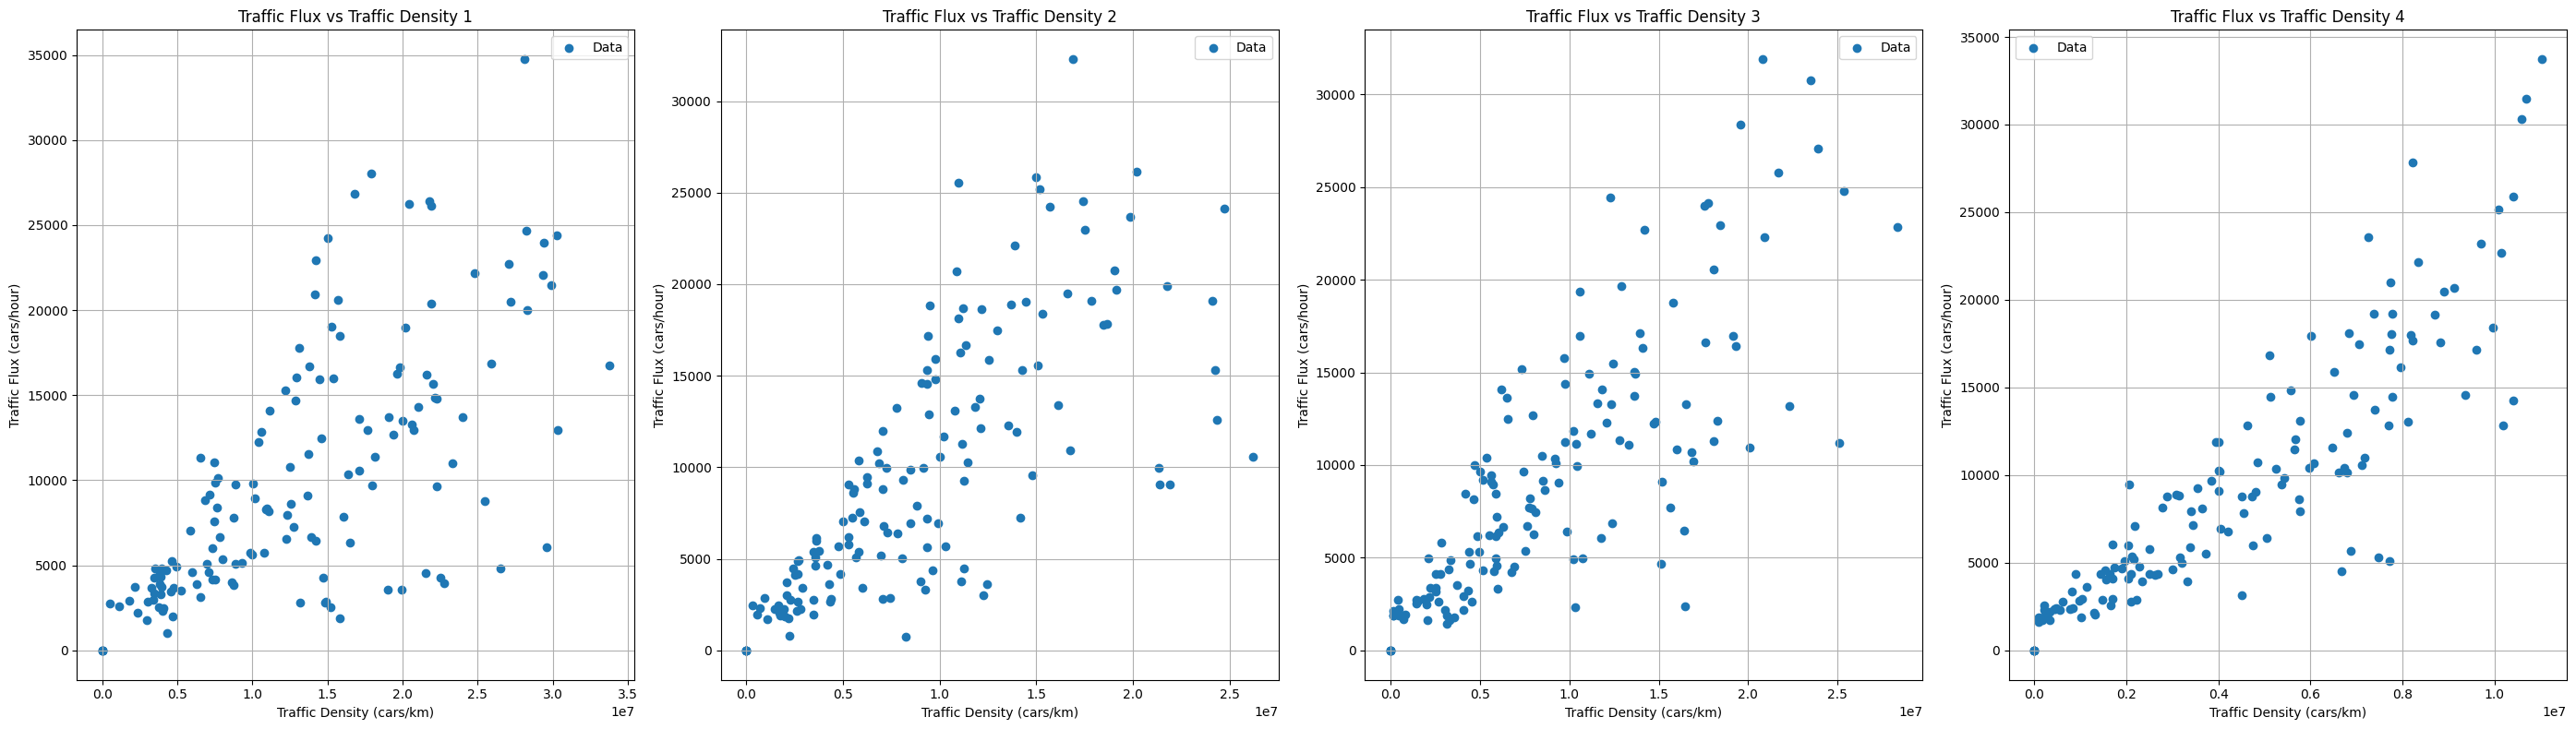

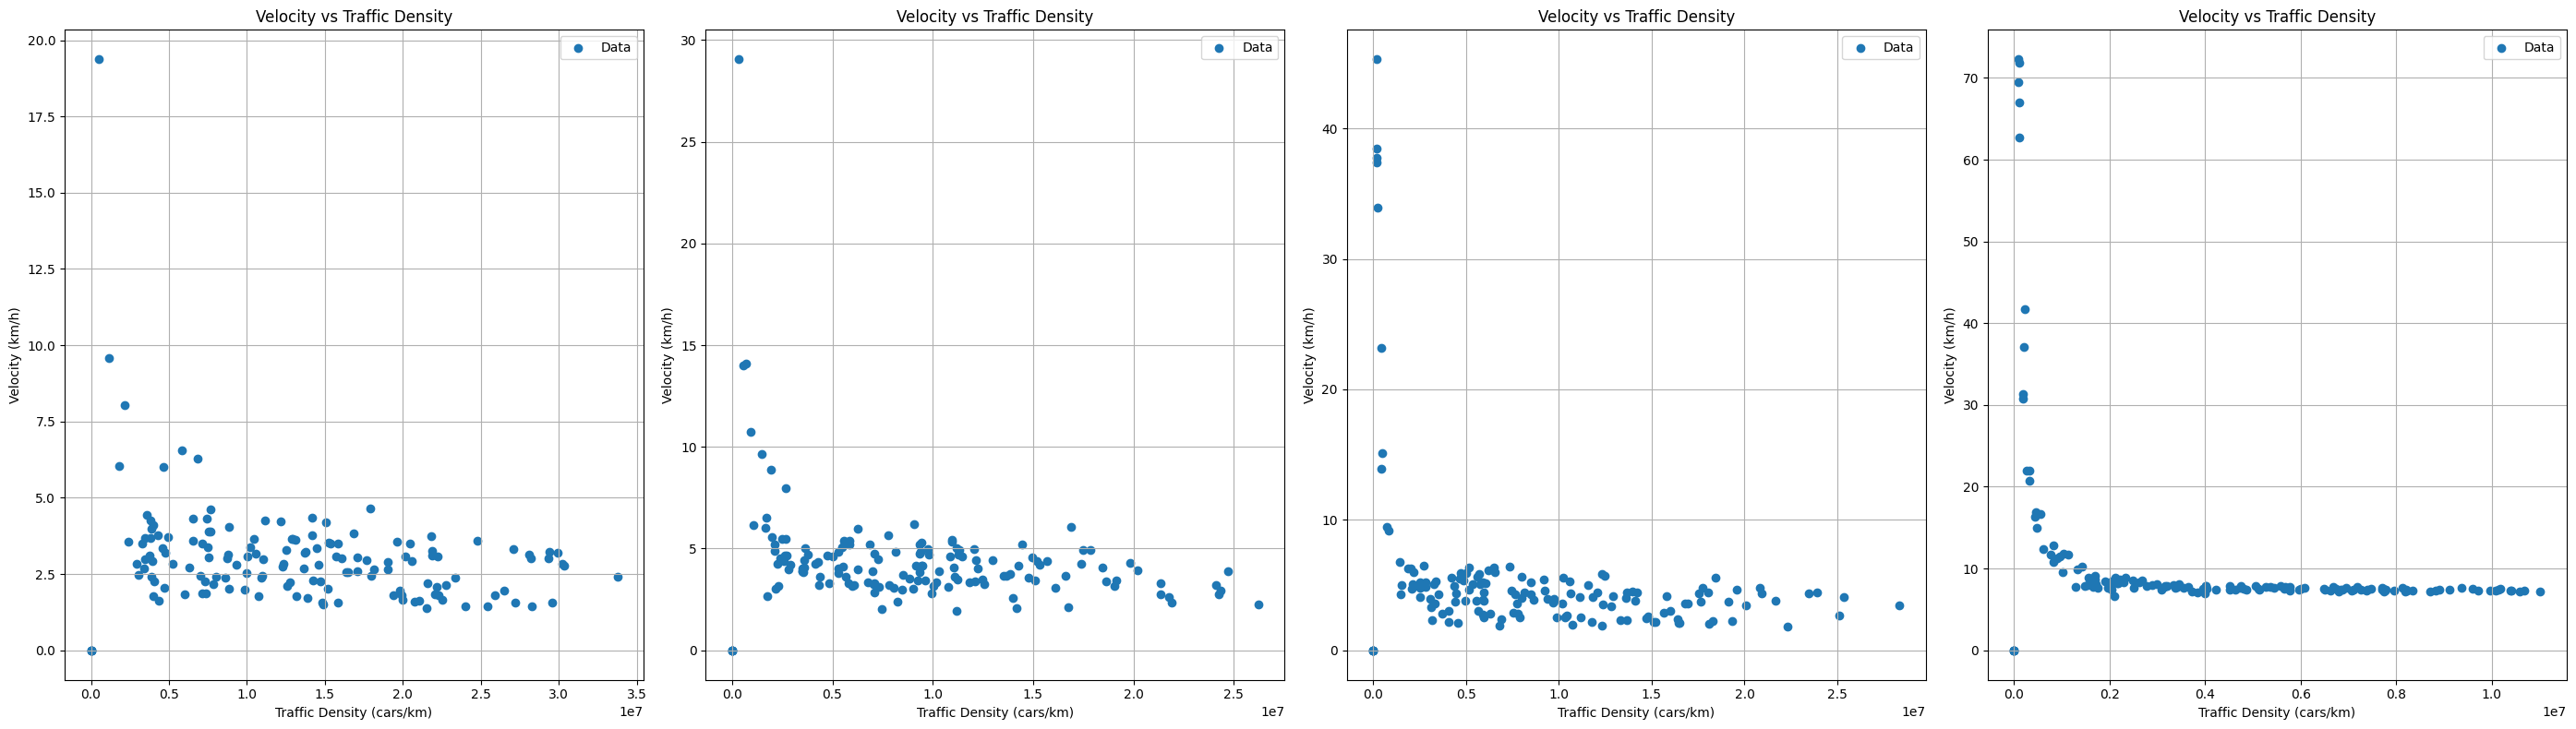

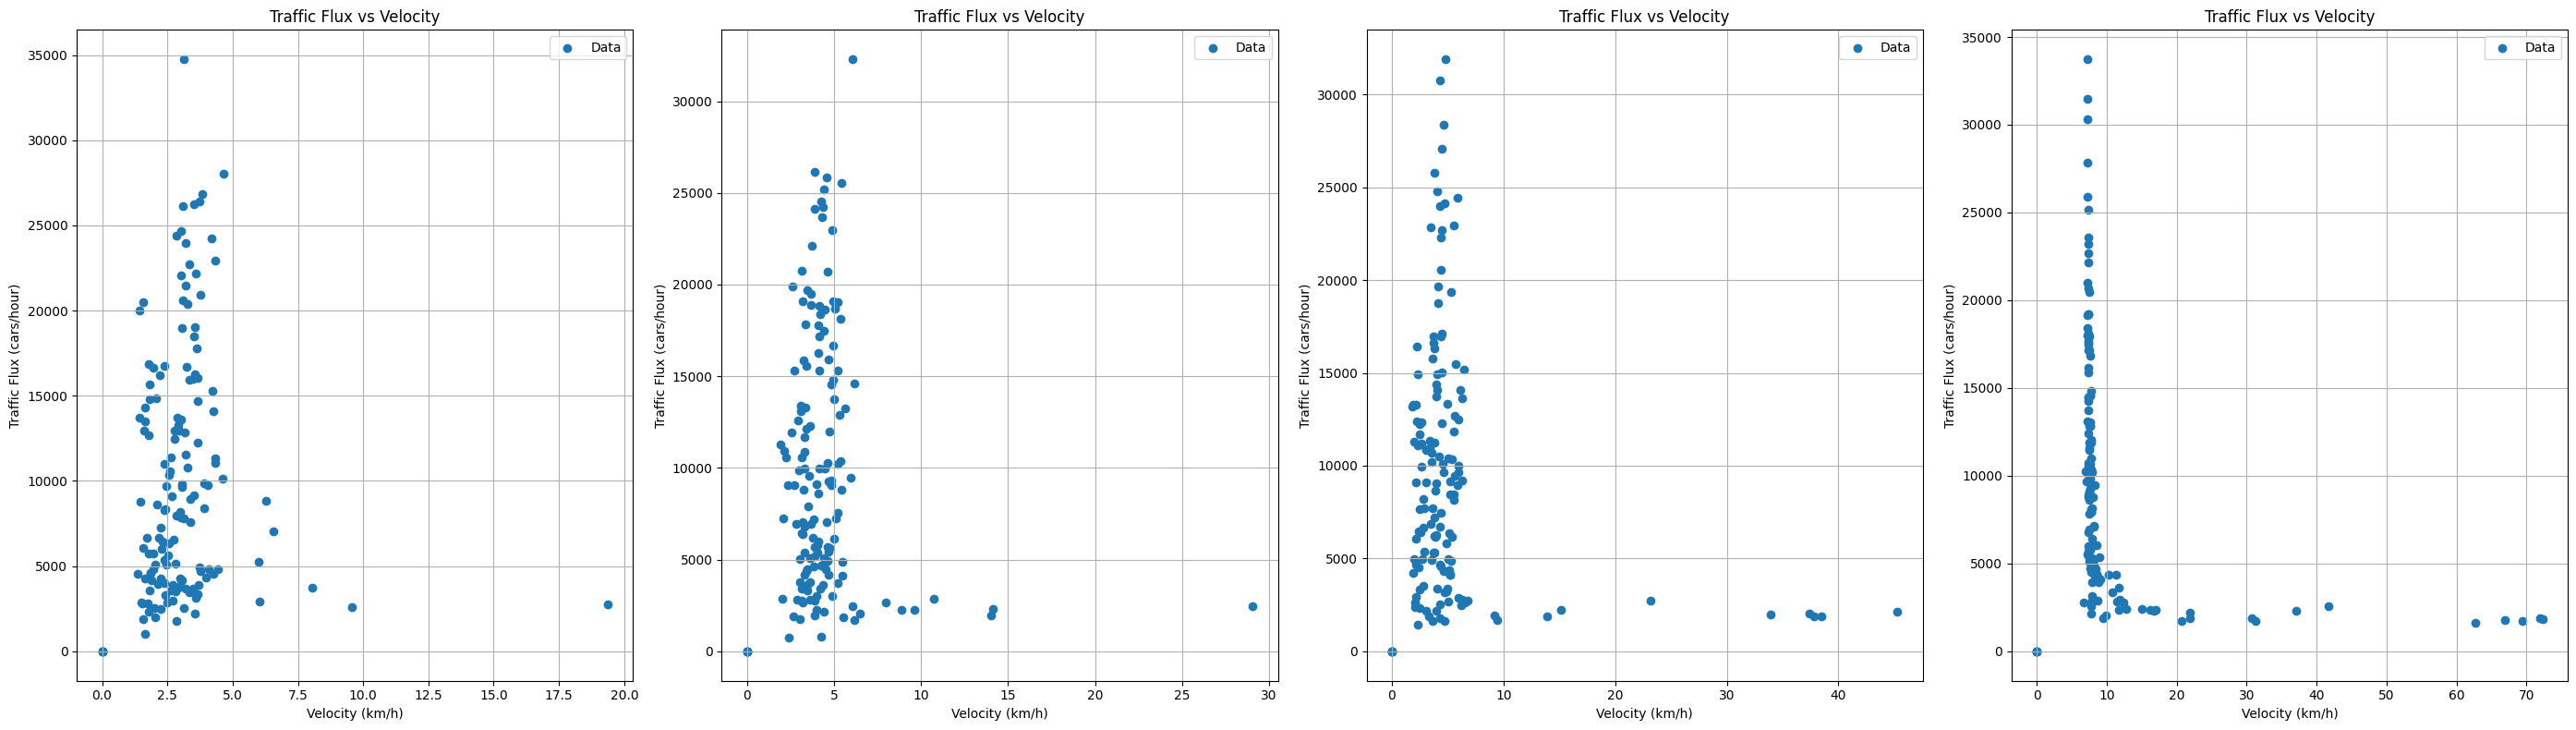

In [44]:
# Flux vs Density
plt.figure(figsize=(28,8))
# Traffic Flux vs Density
# plt.subplot(1,3,1)
plt.subplot(1,4,1)
plt.scatter(traffic_density_data11, average_flux_data11, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 1")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(traffic_density_data22, average_flux_data22, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 2")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(traffic_density_data33, average_flux_data33, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 3")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(traffic_density_data44, average_flux_data44, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 4")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Velocity vs Density
plt.figure(figsize=(28,8))
# plt.subplot(1,3,2)
plt.subplot(1,4,1)
plt.scatter(traffic_density_data11, average_velocities_fd_data11, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(traffic_density_data22, average_velocities_fd_data22, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(traffic_density_data33, average_velocities_fd_data33, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(traffic_density_data44, average_velocities_fd_data44, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Velocity vs Flux
plt.figure(figsize=(28,8))
# plt.subplot(1,3,3)
plt.subplot(1,4,1)
plt.scatter(average_velocities_fd_data11, average_flux_data11, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(average_velocities_fd_data22, average_flux_data22, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(average_velocities_fd_data33, average_flux_data33, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(average_velocities_fd_data44, average_flux_data44, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
# print('end1')

In [53]:
# Simulation parameters
road_length = 400  # meters
signal_position1 = 100  # meters
signal_position2 = 200  # meters
signal_position3 = 300  # meters
simulation_duration = 3600  # seconds
time_step = 1  # second
red_phase_duration = 40  # seconds
green_phase_duration = 30  # seconds
max_speed = 30  # meters/second
reaction_time = 1.5  # seconds
safe_distance = 5  # meters
normal_deceleration = -2.5  # meters/second^2
# spawn_rate = 1  # average number of vehicles spawned per second
flux = 0 # number of cars traveled across the road
average_velocity_sum = 0 # for fundamental diagram average velocity calculation
total_cars = 0 # for fundamental diagram average velocity calculation

# Initialize variables
signal_phase1 = 'green'
signal_phase2 = 'red'
signal_phase3 = 'red'
phase_time_remaining1 = green_phase_duration
phase_time_remaining2 = red_phase_duration
phase_time_remaining3 = red_phase_duration
vehicles = []
vehicle_trajectories = {}
vehicle_id_counter = 0
average_velocities = []

#Fundamental diagram variables
average_flux = []
traffic_density_list = []
average_velocities_fd = []


In [54]:
import numpy as np
spawn_rates_list = np.linspace(1, 5, 5)
traffic_density_list11 = []
average_flux11 = []
average_velocities_fd11 = []
traffic_density_list22 = []
average_flux22 = []
average_velocities_fd22 = []
traffic_density_list33 = []
average_flux33 = []
average_velocities_fd33 = []
traffic_density_list44 = []
average_flux44 = []
average_velocities_fd44 = []
for rate in spawn_rates_list:
    traffic_density_list1,average_flux1,average_velocities_fd1,traffic_density_list2,average_flux2,average_velocities_fd2,\
        traffic_density_list3,average_flux3,average_velocities_fd3,traffic_density_list4,average_flux4,average_velocities_fd4=\
            simulation_func(rate,time_step, phase_time_remaining1,phase_time_remaining2,phase_time_remaining3,signal_phase1,\
                    signal_phase2,signal_phase3,green_phase_duration)
    traffic_density_list11.append(traffic_density_list1)
    average_flux11.append(average_flux1)
    average_velocities_fd11.append(average_velocities_fd1)
    traffic_density_list22.append(traffic_density_list2)
    average_flux22.append(average_flux2)
    average_velocities_fd22.append(average_velocities_fd2)
    traffic_density_list33.append(traffic_density_list3)
    average_flux33.append(average_flux3)
    average_velocities_fd33.append(average_velocities_fd3)
    traffic_density_list44.append(traffic_density_list4)
    average_flux44.append(average_flux4)
    average_velocities_fd44.append(average_velocities_fd4)

In [55]:
# traffic_density_list
traffic_density_data11 =[]
average_flux_data11 =[]
average_velocities_fd_data11 =[]
traffic_density_data22 =[]
average_flux_data22 =[]
average_velocities_fd_data22 =[]
traffic_density_data33 =[]
average_flux_data33 =[]
average_velocities_fd_data33 =[]
traffic_density_data44 =[]
average_flux_data44 =[]
average_velocities_fd_data44 =[]

for i in traffic_density_list11:
    traffic_density_data11 = traffic_density_data11 + i

for i in average_flux11:
    average_flux_data11 = average_flux_data11 + i 

for i in average_velocities_fd11:
    average_velocities_fd_data11 = average_velocities_fd_data11 + i

for i in traffic_density_list22:
    traffic_density_data22 = traffic_density_data22 + i

for i in average_flux22:
    average_flux_data22 = average_flux_data22 + i 

for i in average_velocities_fd22:
    average_velocities_fd_data22 = average_velocities_fd_data22 + i

for i in traffic_density_list33:
    traffic_density_data33 = traffic_density_data33 + i

for i in average_flux33:
    average_flux_data33 = average_flux_data33 + i 

for i in average_velocities_fd33:
    average_velocities_fd_data33 = average_velocities_fd_data33 + i

for i in traffic_density_list44:
    traffic_density_data44 = traffic_density_data44 + i

for i in average_flux44:
    average_flux_data44 = average_flux_data44 + i 

for i in average_velocities_fd44:
    average_velocities_fd_data44 = average_velocities_fd_data44 + i

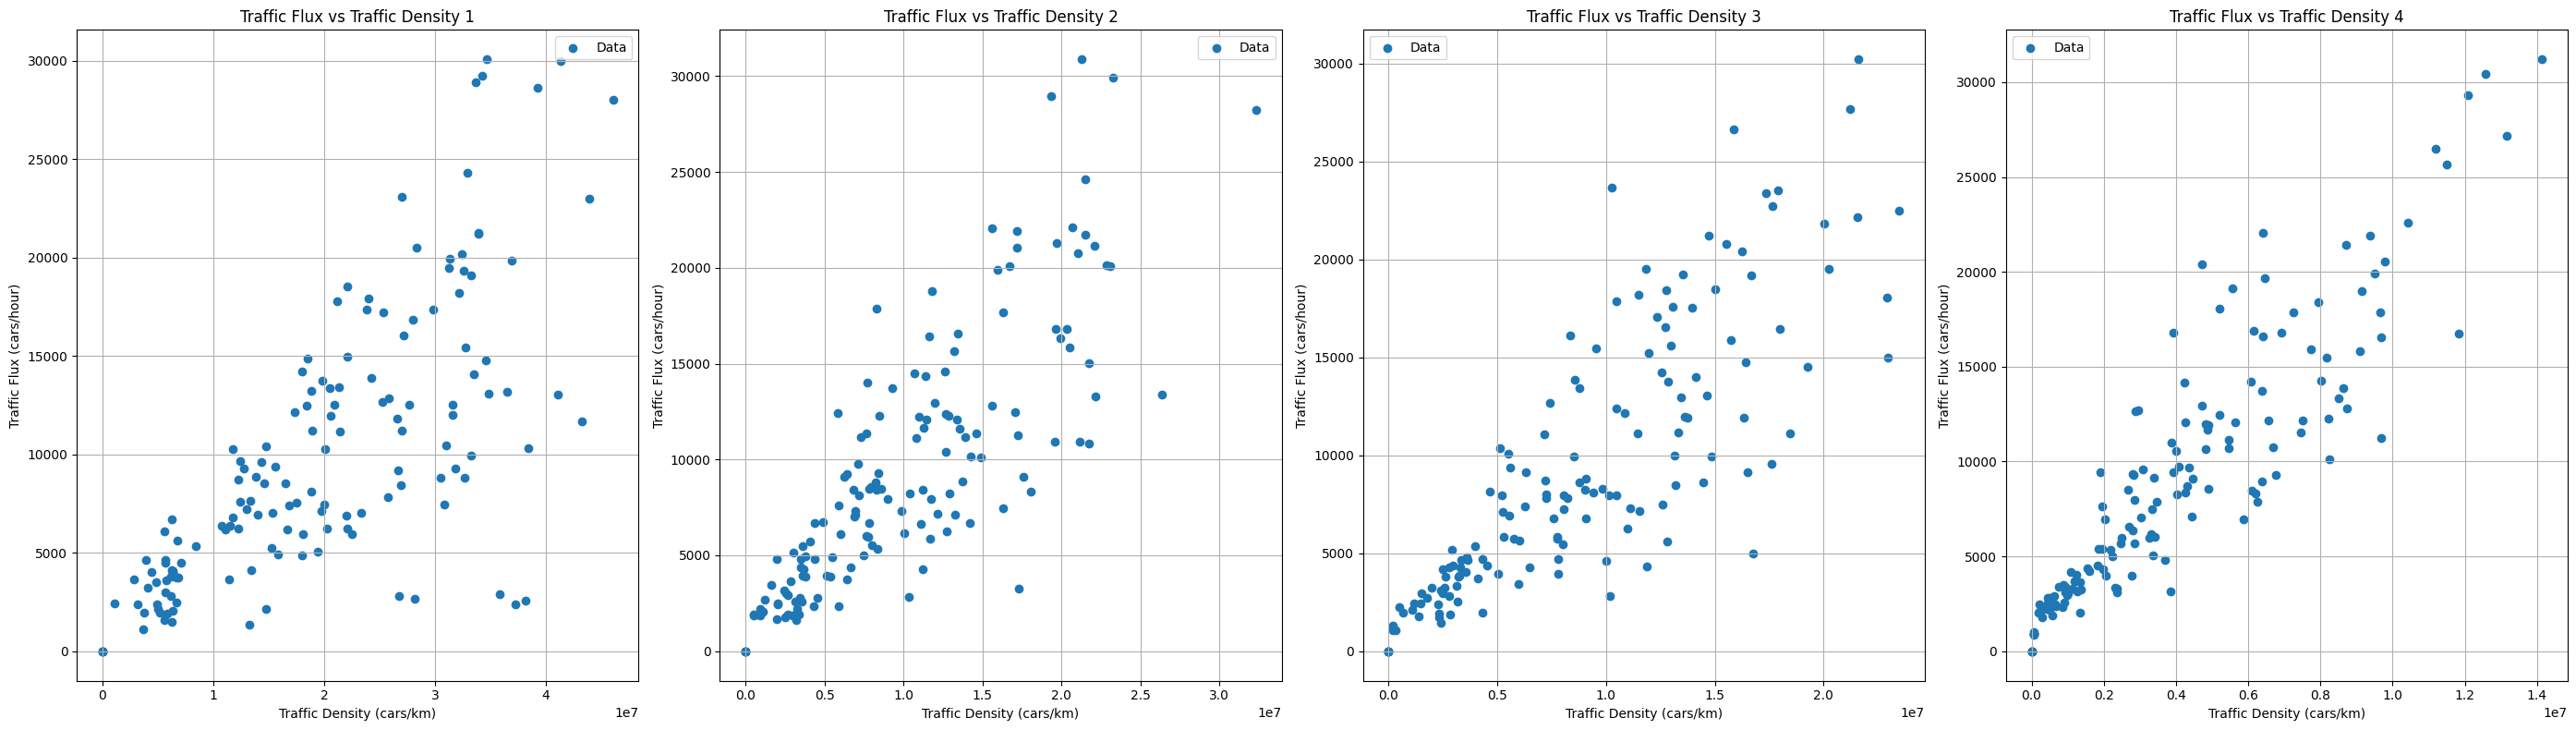

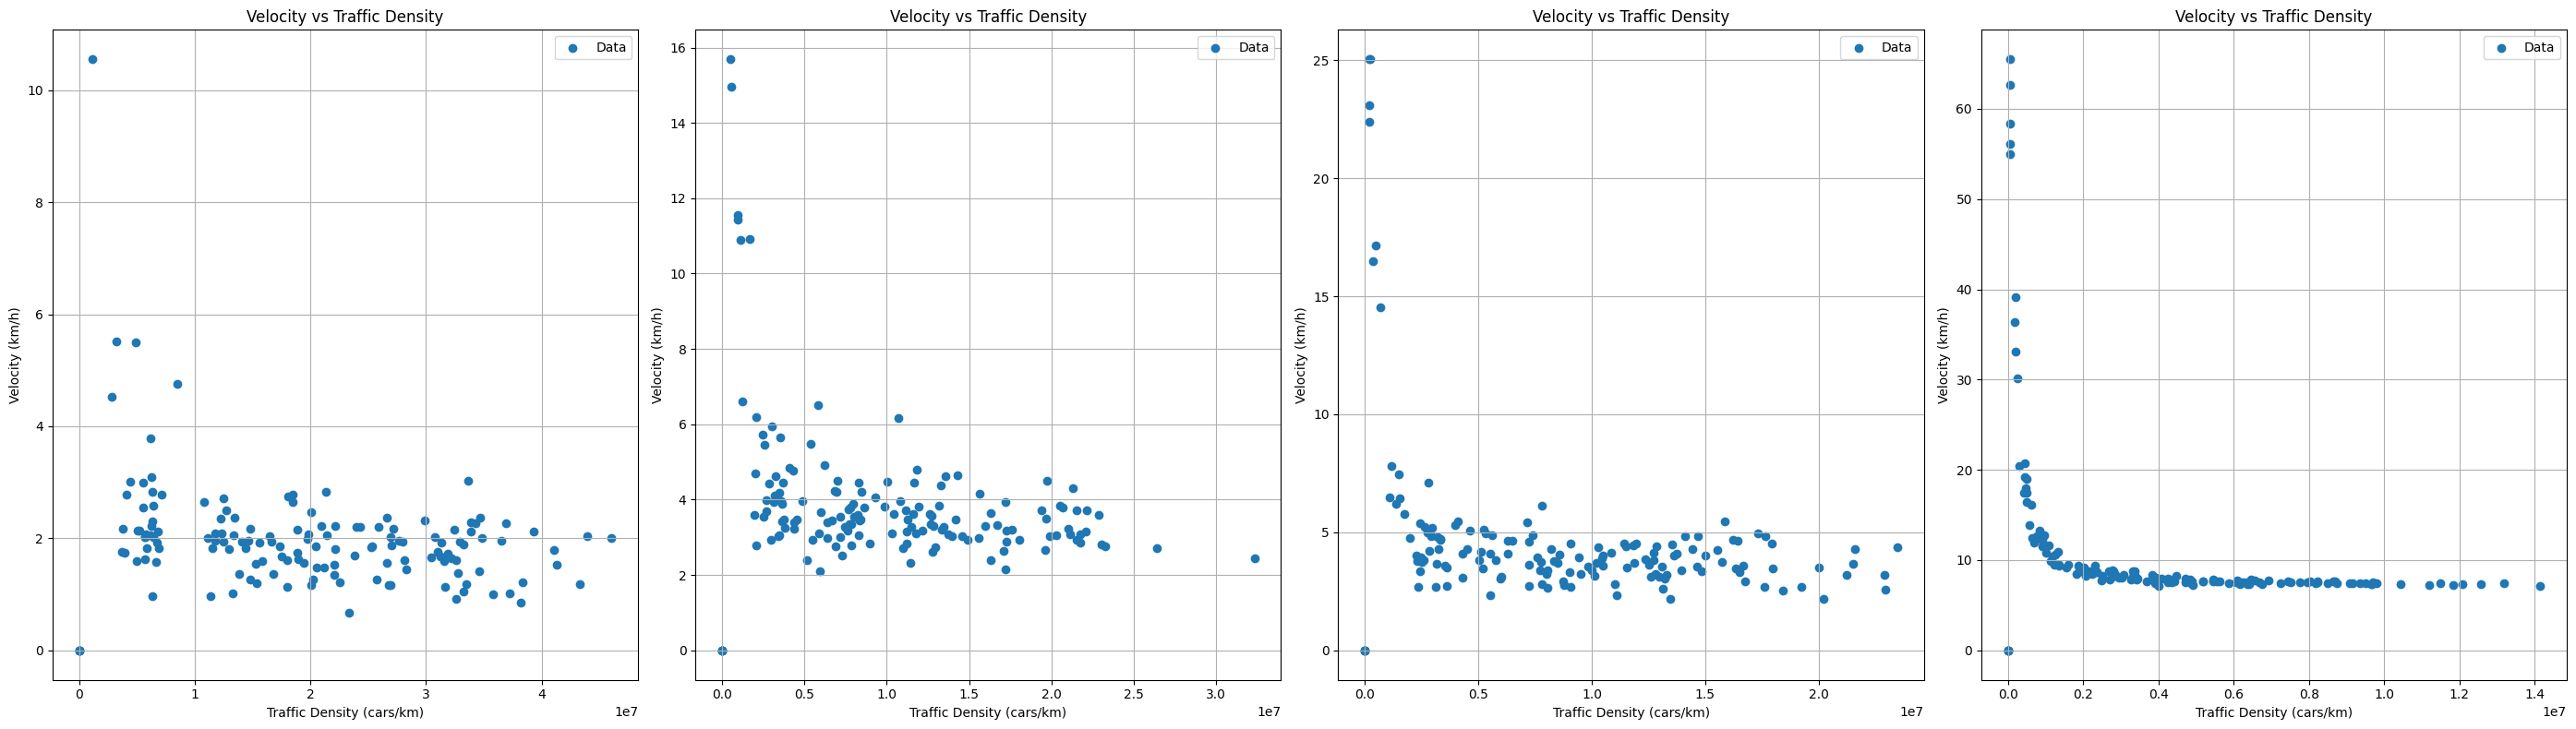

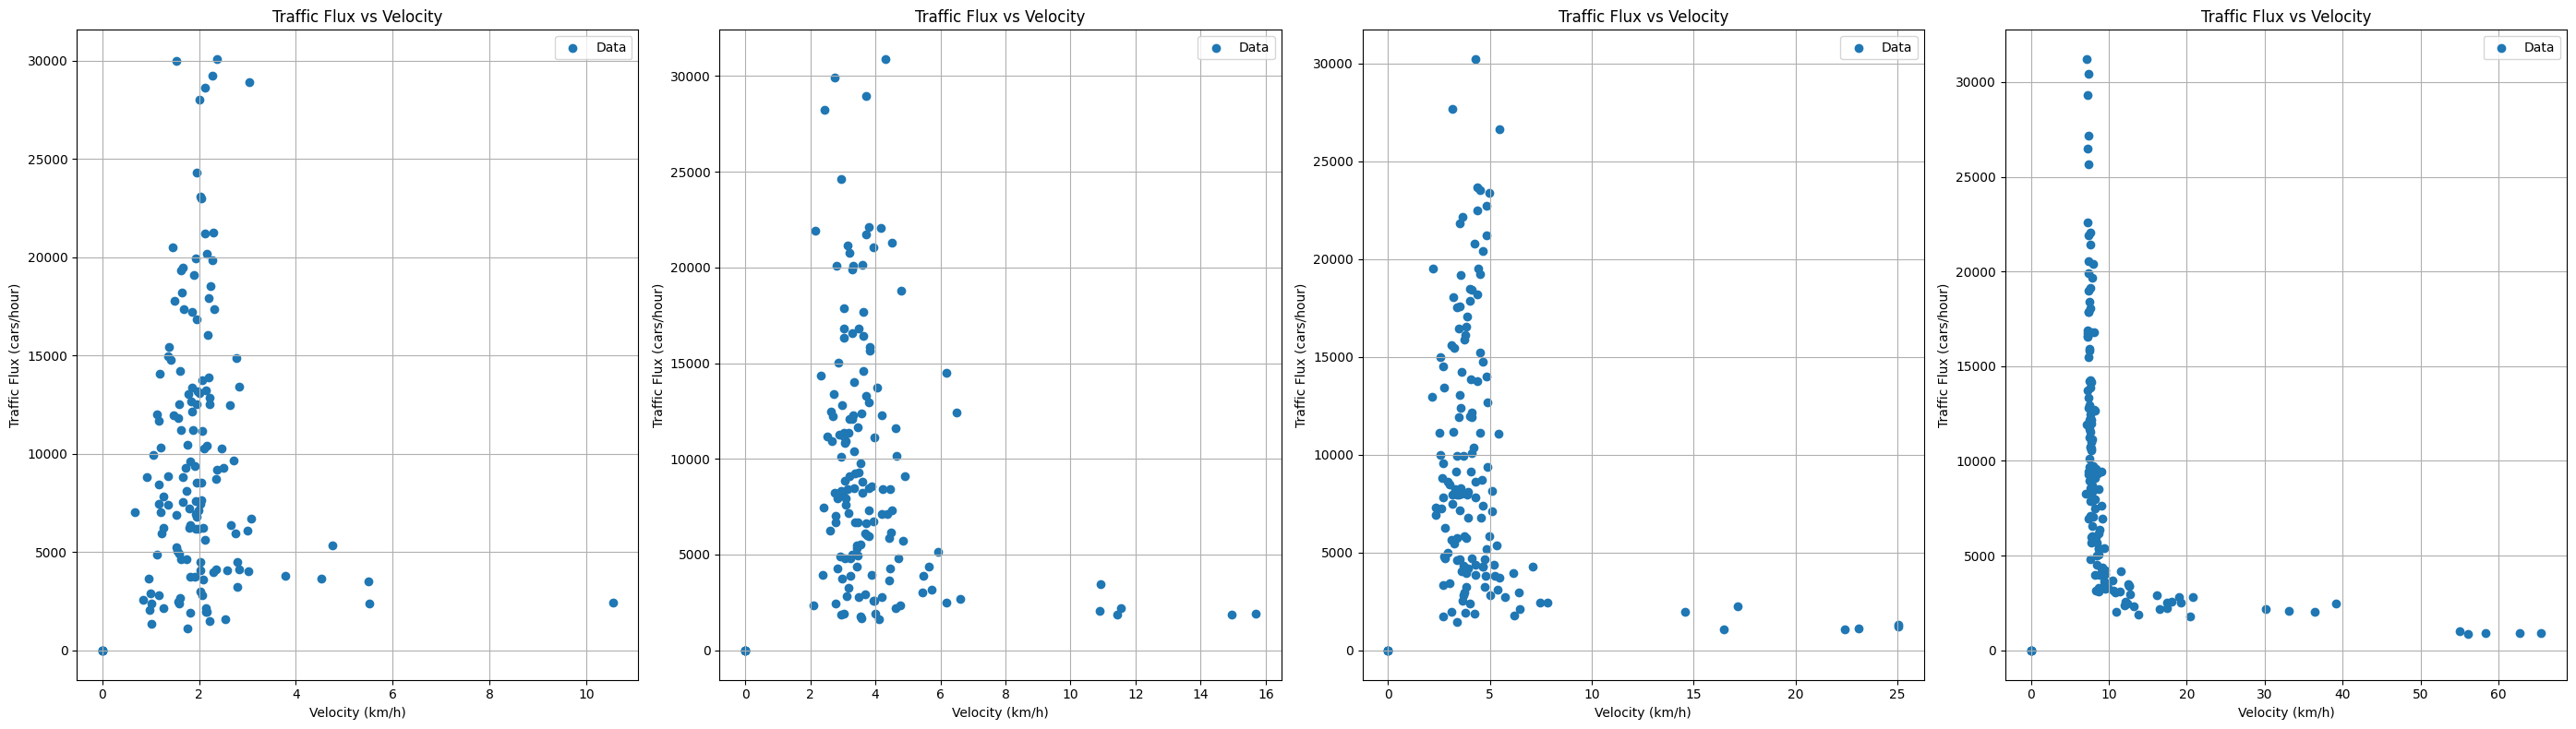

In [57]:
# Flux vs Density
plt.figure(figsize=(28,8))
# Traffic Flux vs Density
# plt.subplot(1,3,1)
plt.subplot(1,4,1)
plt.scatter(traffic_density_data11, average_flux_data11, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 1")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(traffic_density_data22, average_flux_data22, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 2")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(traffic_density_data33, average_flux_data33, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 3")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(traffic_density_data44, average_flux_data44, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 4")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Velocity vs Density
plt.figure(figsize=(28,8))
# plt.subplot(1,3,2)
plt.subplot(1,4,1)
plt.scatter(traffic_density_data11, average_velocities_fd_data11, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(traffic_density_data22, average_velocities_fd_data22, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(traffic_density_data33, average_velocities_fd_data33, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(traffic_density_data44, average_velocities_fd_data44, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Velocity vs Flux
plt.figure(figsize=(28,8))
# plt.subplot(1,3,3)
plt.subplot(1,4,1)
plt.scatter(average_velocities_fd_data11, average_flux_data11, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(average_velocities_fd_data22, average_flux_data22, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(average_velocities_fd_data33, average_flux_data33, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(average_velocities_fd_data44, average_flux_data44, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
# print('end1')

In [49]:
# Simulation parameters
road_length = 400  # meters
signal_position1 = 100  # meters
signal_position2 = 200  # meters
signal_position3 = 300  # meters
simulation_duration = 3600  # seconds
time_step = 1  # second
red_phase_duration = 40  # seconds
green_phase_duration = 20  # seconds
max_speed = 30  # meters/second
reaction_time = 1.5  # seconds
safe_distance = 5  # meters
normal_deceleration = -2.5  # meters/second^2
# spawn_rate = 1  # average number of vehicles spawned per second
flux = 0 # number of cars traveled across the road
average_velocity_sum = 0 # for fundamental diagram average velocity calculation
total_cars = 0 # for fundamental diagram average velocity calculation

# Initialize variables
signal_phase1 = 'green'
signal_phase2 = 'red'
signal_phase3 = 'red'
phase_time_remaining1 = green_phase_duration
phase_time_remaining2 = red_phase_duration
phase_time_remaining3 = red_phase_duration
vehicles = []
vehicle_trajectories = {}
vehicle_id_counter = 0
average_velocities = []

#Fundamental diagram variables
average_flux = []
traffic_density_list = []
average_velocities_fd = []


In [50]:
import numpy as np
spawn_rates_list = np.linspace(1, 5, 5)
traffic_density_list11 = []
average_flux11 = []
average_velocities_fd11 = []
traffic_density_list22 = []
average_flux22 = []
average_velocities_fd22 = []
traffic_density_list33 = []
average_flux33 = []
average_velocities_fd33 = []
traffic_density_list44 = []
average_flux44 = []
average_velocities_fd44 = []
for rate in spawn_rates_list:
    traffic_density_list1,average_flux1,average_velocities_fd1,traffic_density_list2,average_flux2,average_velocities_fd2,\
        traffic_density_list3,average_flux3,average_velocities_fd3,traffic_density_list4,average_flux4,average_velocities_fd4=\
            simulation_func(rate,time_step, phase_time_remaining1,phase_time_remaining2,phase_time_remaining3,signal_phase1,\
                    signal_phase2,signal_phase3,green_phase_duration)
    traffic_density_list11.append(traffic_density_list1)
    average_flux11.append(average_flux1)
    average_velocities_fd11.append(average_velocities_fd1)
    traffic_density_list22.append(traffic_density_list2)
    average_flux22.append(average_flux2)
    average_velocities_fd22.append(average_velocities_fd2)
    traffic_density_list33.append(traffic_density_list3)
    average_flux33.append(average_flux3)
    average_velocities_fd33.append(average_velocities_fd3)
    traffic_density_list44.append(traffic_density_list4)
    average_flux44.append(average_flux4)
    average_velocities_fd44.append(average_velocities_fd4)

In [51]:
# traffic_density_list
traffic_density_data11 =[]
average_flux_data11 =[]
average_velocities_fd_data11 =[]
traffic_density_data22 =[]
average_flux_data22 =[]
average_velocities_fd_data22 =[]
traffic_density_data33 =[]
average_flux_data33 =[]
average_velocities_fd_data33 =[]
traffic_density_data44 =[]
average_flux_data44 =[]
average_velocities_fd_data44 =[]

for i in traffic_density_list11:
    traffic_density_data11 = traffic_density_data11 + i

for i in average_flux11:
    average_flux_data11 = average_flux_data11 + i 

for i in average_velocities_fd11:
    average_velocities_fd_data11 = average_velocities_fd_data11 + i

for i in traffic_density_list22:
    traffic_density_data22 = traffic_density_data22 + i

for i in average_flux22:
    average_flux_data22 = average_flux_data22 + i 

for i in average_velocities_fd22:
    average_velocities_fd_data22 = average_velocities_fd_data22 + i

for i in traffic_density_list33:
    traffic_density_data33 = traffic_density_data33 + i

for i in average_flux33:
    average_flux_data33 = average_flux_data33 + i 

for i in average_velocities_fd33:
    average_velocities_fd_data33 = average_velocities_fd_data33 + i

for i in traffic_density_list44:
    traffic_density_data44 = traffic_density_data44 + i

for i in average_flux44:
    average_flux_data44 = average_flux_data44 + i 

for i in average_velocities_fd44:
    average_velocities_fd_data44 = average_velocities_fd_data44 + i

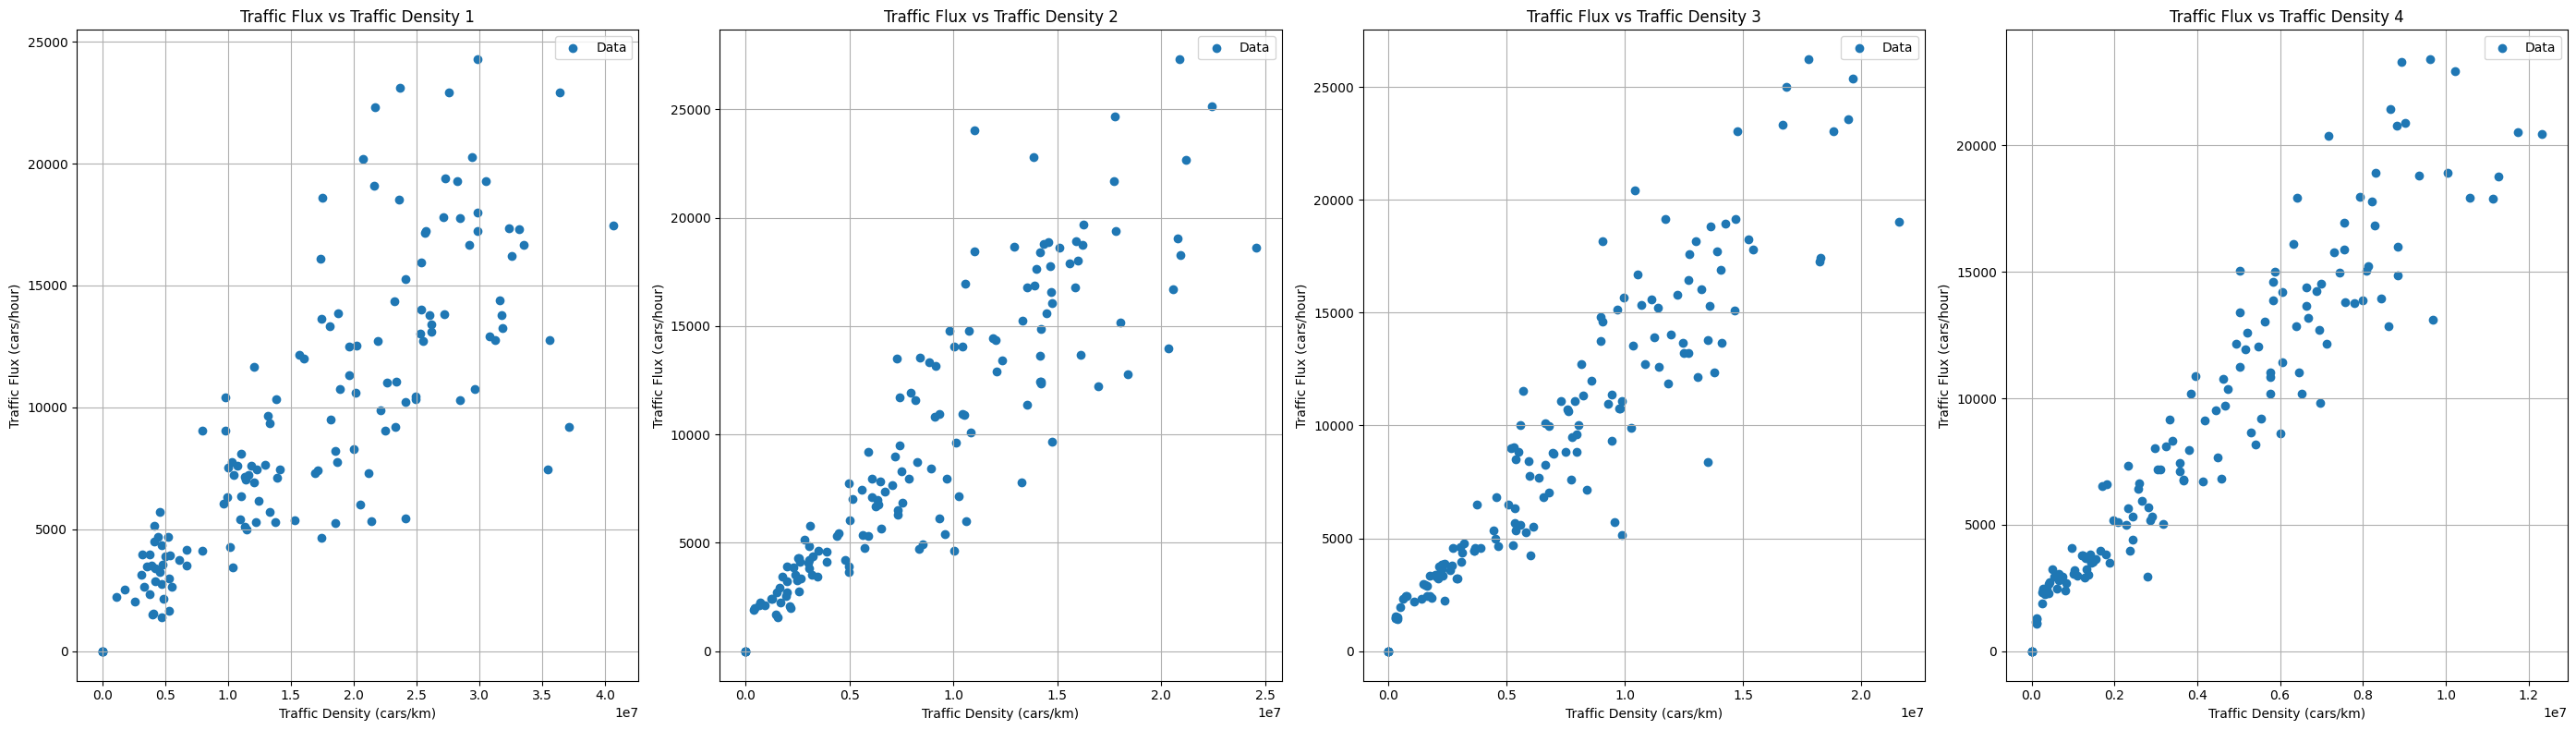

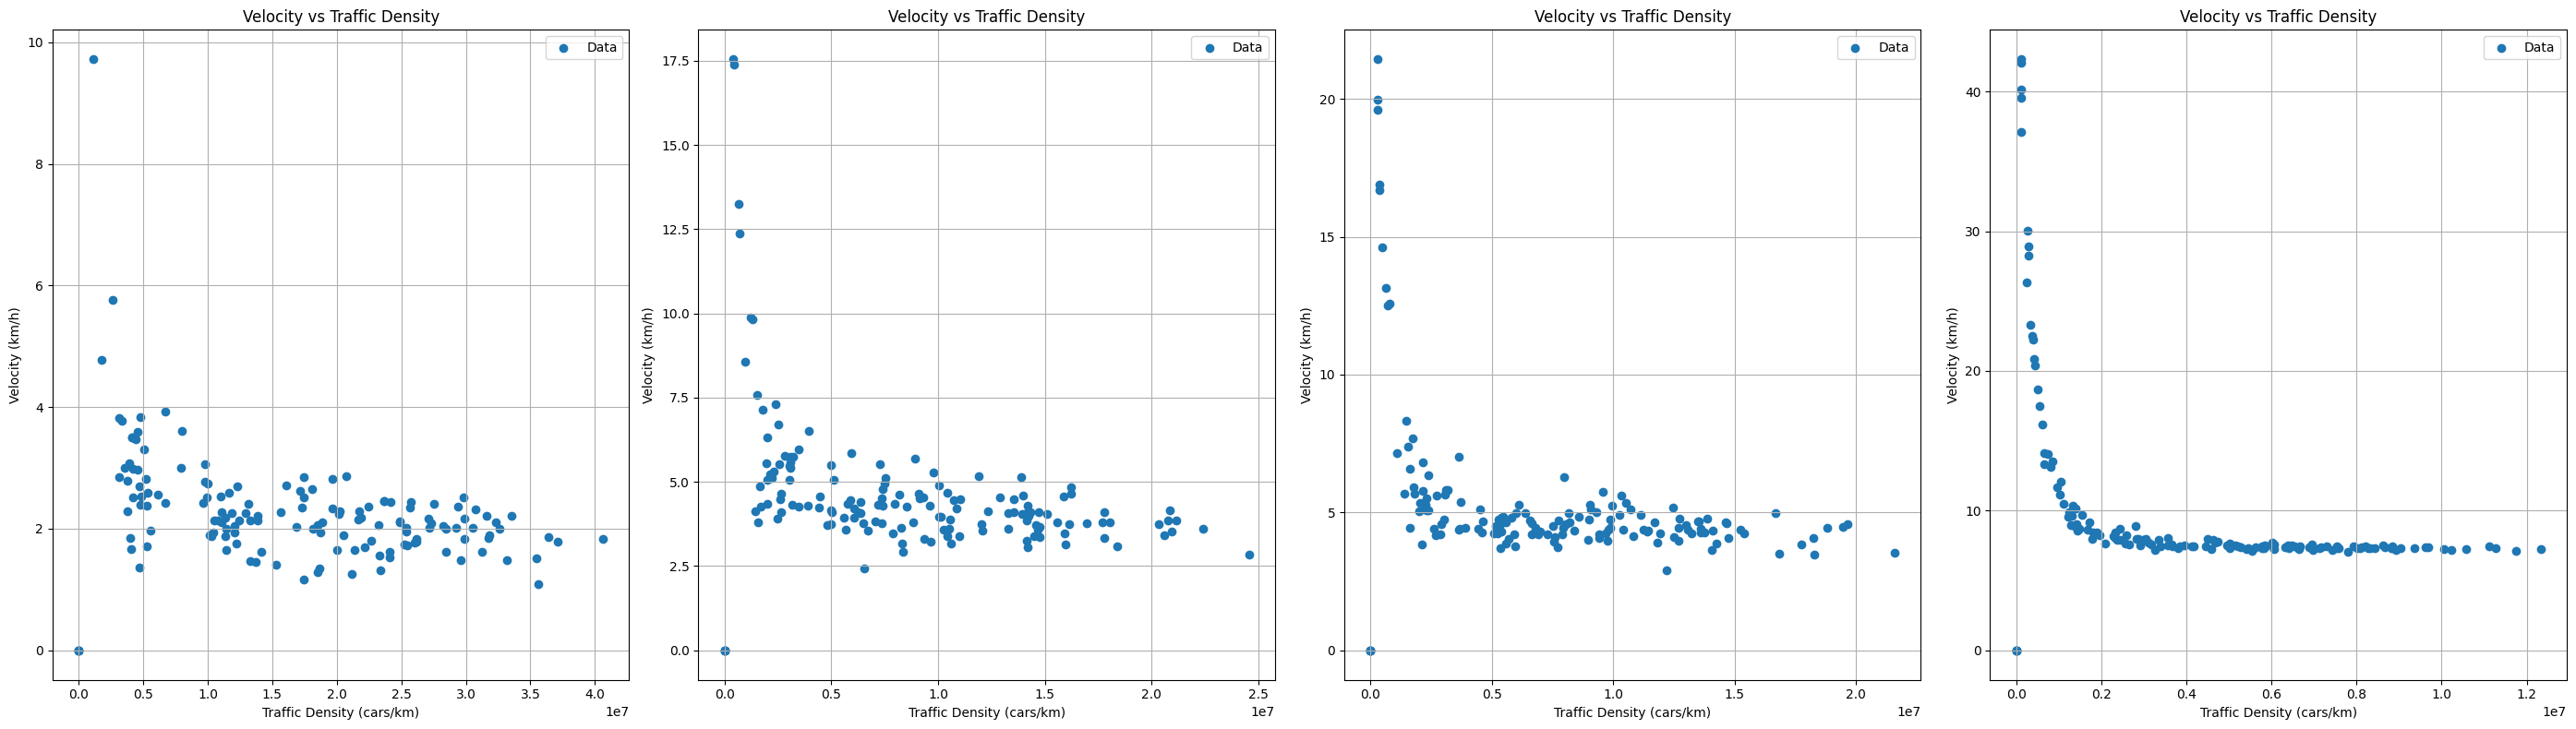

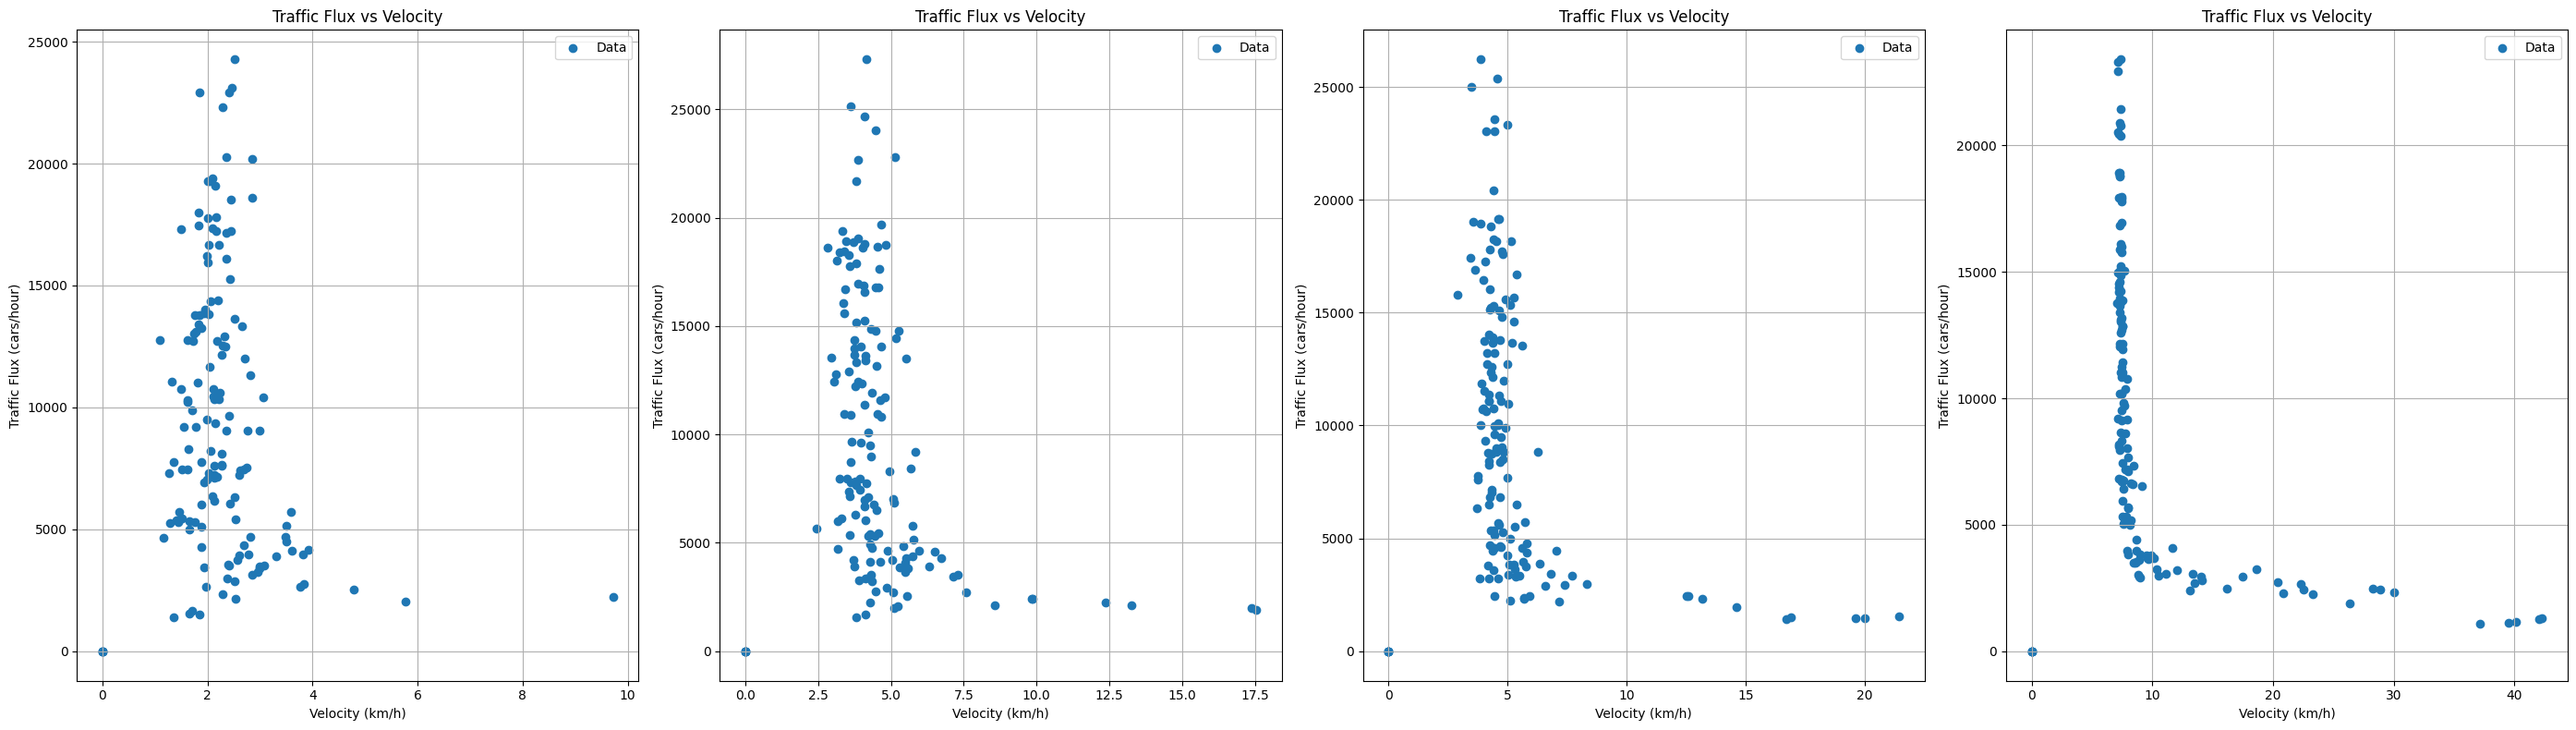

In [52]:
# Flux vs Density
plt.figure(figsize=(28,8))
# Traffic Flux vs Density
# plt.subplot(1,3,1)
plt.subplot(1,4,1)
plt.scatter(traffic_density_data11, average_flux_data11, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 1")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(traffic_density_data22, average_flux_data22, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 2")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(traffic_density_data33, average_flux_data33, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 3")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(traffic_density_data44, average_flux_data44, label='Data')
# plt.plot(smooth_densities, smooth_fluxes_from_density, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Traffic Density 4")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Velocity vs Density
plt.figure(figsize=(28,8))
# plt.subplot(1,3,2)
plt.subplot(1,4,1)
plt.scatter(traffic_density_data11, average_velocities_fd_data11, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(traffic_density_data22, average_velocities_fd_data22, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(traffic_density_data33, average_velocities_fd_data33, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(traffic_density_data44, average_velocities_fd_data44, label='Data')
# plt.plot(smooth_densities, smooth_velocities, 'r-', label='Best Fit')
plt.title("Velocity vs Traffic Density")
plt.xlabel("Traffic Density (cars/km)")
plt.ylabel("Velocity (km/h)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Velocity vs Flux
plt.figure(figsize=(28,8))
# plt.subplot(1,3,3)
plt.subplot(1,4,1)
plt.scatter(average_velocities_fd_data11, average_flux_data11, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,2)
plt.scatter(average_velocities_fd_data22, average_flux_data22, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,3)
plt.scatter(average_velocities_fd_data33, average_flux_data33, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.subplot(1,4,4)
plt.scatter(average_velocities_fd_data44, average_flux_data44, label='Data')
# plt.plot(smooth_velocities, smooth_fluxes_from_velocity, 'r-', label='Best Fit')
plt.title("Traffic Flux vs Velocity")
plt.xlabel("Velocity (km/h)")
plt.ylabel("Traffic Flux (cars/hour)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
# print('end1')

In [47]:
# # Plotting the results
# time_steps = np.arange(simulation_duration)

# # Vehicle Positions Over Time
# plt.figure(figsize=(10, 6))
# for vehicle_id, data in vehicle_trajectories.items():
#     valid_times = [i for i, p in enumerate(data['positions']) if p is not None]
#     valid_positions = [p for p in data['positions'] if p is not None]
#     if valid_positions:
#         plt.plot(valid_times, valid_positions)
# plt.xlabel('Time (s)')
# plt.ylabel('Position (m)')
# plt.title(f'Vehicle Positions Over Time (Total Vehicles: {vehicle_id_counter})')
# plt.show()

# # Individual Velocities Over Time
# plt.figure(figsize=(10, 6))
# for vehicle_id, data in vehicle_trajectories.items():
#     valid_times = [i for i, v in enumerate(data['velocities']) if v is not None]
#     valid_velocities = [v for v in data['velocities'] if v is not None]
#     if valid_velocities:
#         plt.plot(valid_times, valid_velocities)
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title(f'Individual Velocities Over Time (Total Vehicles: {vehicle_id_counter})')
# plt.show()

# # Average Velocities Over Time
# plt.figure(figsize=(10, 6))
# plt.plot(time_steps, average_velocities)
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title(f'Average Velocities Over Time (Total Vehicles: {vehicle_id_counter})')
# plt.show()

In [29]:
# # Simulation loop
# current_time = 0
# while current_time < simulation_duration:
#     # Spawn vehicles
#     num_spawned_vehicles = poisson.rvs(spawn_rate * time_step)
#     for _ in range(num_spawned_vehicles):
#         new_vehicle = Vehicle(vehicle_id_counter)
#         vehicles.append(new_vehicle)
#         # Initialize past values as zeros
#         vehicle_trajectories[vehicle_id_counter] = {'positions': [0]*current_time, 'velocities': [0]*current_time} 
#         vehicle_id_counter += 1

#     # Update traffic signal
#     phase_time_remaining1 -= time_step
#     if phase_time_remaining1 <= 0:
#         signal_phase1 = 'red' if signal_phase1 == 'green' else 'green'
#         phase_time_remaining1 = red_phase_duration if signal_phase1 == 'red' else green_phase_duration
    
#     phase_time_remaining2 -= time_step
#     if phase_time_remaining2 <= 0:
#         signal_phase2 = 'red' if signal_phase2 == 'green' else 'green'
#         phase_time_remaining2 = red_phase_duration if signal_phase2 == 'red' else green_phase_duration
    
#     phase_time_remaining3 -= time_step
#     if phase_time_remaining3 <= 0:
#         signal_phase3 = 'red' if signal_phase3 == 'green' else 'green'
#         phase_time_remaining3 = red_phase_duration if signal_phase3 == 'red' else green_phase_duration

#     # Update vehicle positions and velocities
#     for vehicle in vehicles:
#         update_vehicle_position(vehicle, vehicles, signal_phase1, signal_phase2, signal_phase3,\
#                                 signal_position1, signal_position2, signal_position3)
#         vehicle_trajectories[vehicle.id]['positions'].append(vehicle.position)
# #         print(vehicle.position,vehicle.velocity)
#         vehicle_trajectories[vehicle.id]['velocities'].append(vehicle.velocity)
# #     print('############################')
#     # Calculate average velocity
#     current_num_vehicles = len(vehicles)
#     total_velocity = sum(vehicle.velocity for vehicle in vehicles)
#     average_velocity = total_velocity / current_num_vehicles if current_num_vehicles > 0 else 0
#     average_velocities.append(average_velocity)

#     # Fundamental Diagram Average velocity
#     average_velocity_sum = average_velocity_sum + total_velocity
#     total_cars = total_cars + current_num_vehicles
#     # convert from m/s to km/h
#     tmp_average_velocity = (average_velocity_sum / total_cars) / current_time * 3.6 if (total_cars > 0 and current_time > 0) else 0 
#     average_velocities_fd.append(tmp_average_velocity)

#     # Fundamental Diagram add flux if vehicles left the road
#     for v in vehicles:
#         if v.position >= road_length:
#             flux = flux + 1
#     tmp_flux = flux / current_time * 3600 if current_time > 0 else 0 # convert to cars/hour
#     average_flux.append(tmp_flux)
    
#     # Remove vehicles that have left the road
#     vehicles = [v for v in vehicles if v.position < road_length]

#     # Fundamental Diagram Add Traffic density count for how many cars still on road
#     tmp_density = current_num_vehicles / (road_length / 1000)
#     traffic_density_list.append(tmp_density)
    
#     # Fill in missing time points for vehicles that have left
#     for vehicle_id, data in vehicle_trajectories.items():
#         if len(data['positions']) < current_time + 1:
#             data['positions'].append(None)  # Mark as None for missing data points
#             data['velocities'].append(None)

#     # Increment current time
#     current_time += time_step
